# Project Code: Birth & Naming Trends Analysis

This Jupyter Notebook contains the Python code used for all visualizations and data preprocessing in the project or article titled "Birth & Naming Trends: A Data-Driven Exploration." The full article is available **[here](https://numanwaziri.github.io/posts/birth-naming-trends-analysis).**

# Preprocessing

## Import Packages

In [26]:
import zipfile
import requests
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib import lines, patches
import matplotlib.patheffects as path_effects

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

## Import Data

In [27]:
def download_data(url):
    
    # Check if data folder exist, create if not
    folder_path = 'Data'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
    # Path to download the file to    
    file_path = 'Data/dataset.zip'
    df = None

    # Define a mapping from abbreviated to full state names
    state_dict = {
        'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
        'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
        'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
        'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
        'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
        'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
        'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
        'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
        'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
        'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
        'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah',
        'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
        'WI': 'Wisconsin', 'WY': 'Wyoming', "DC": "District of Columbia"
    }

    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Save the content of the response to a file
        with open(file_path, "wb") as file:
            file.write(response.content)
            print("File downloaded successfully.")

        # Aggregate and transform the txt files inside downloaded zip into one dataset
        with zipfile.ZipFile(file_path) as zf:
            txt_files = [f for f in zf.namelist() if f.endswith("TXT")]
            dataframes = []
            for f in txt_files:
                data = pd.read_csv(zf.open(f), header=None, names=['State', 'Gender', 'Year', 'Name', 'Births'])
                dataframes.append(data)

            df = (pd.concat(dataframes, ignore_index=True)
                  .assign(Year=lambda _df: pd.to_datetime(_df['Year'], format="%Y") + pd.offsets.YearEnd(0),
                          State=lambda _df: _df['State'].map(state_dict)))
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

    return df

url = "https://www.ssa.gov/oact/babynames/state/namesbystate.zip"
df = download_data(url)

File downloaded successfully.


## Verify data

In [4]:
def verify_data(df):
    # Check for missing values in each column
    missing_values = df.isnull().sum()

    # Data types of columns
    data_types = df.dtypes

    # Summary statistics for numeric columns
    numeric_summary = df.select_dtypes(include=np.number).describe()

    # Summary statistics for categorical columns
    categorical_summary = df.select_dtypes(include='object').describe()

    # Unique values for categorical columns
    unique_values = {col: df[col].unique() for col in df.select_dtypes(include='object').columns}

    # Check for zero values in numeric columns
    zero_values = (df.select_dtypes(include=np.number) == 0).sum()

    # Check for duplicated rows
    duplicated_rows = df[df.duplicated()]

    return {
        "Missing Values": missing_values,
        "Data Types": data_types,
        "Numeric Summary": numeric_summary,
        "Categorical Summary": categorical_summary,
        "Unique Values for Categorical Columns": unique_values,
        "Zero Values in Numeric Columns": zero_values,
        "Duplicated Rows": duplicated_rows
    }

# Perform data verification
verification_results = verify_data(df)

# Display verification results
for key, value in verification_results.items():
    print(f"\n{key}:\n{value}\n")


Missing Values:
State     0
Gender    0
Year      0
Name      0
Births    0
dtype: int64


Data Types:
State             object
Gender            object
Year      datetime64[ns]
Name              object
Births             int64
dtype: object


Numeric Summary:
             Births
count  6.408041e+06
mean   5.033971e+01
std    1.720529e+02
min    5.000000e+00
25%    7.000000e+00
50%    1.200000e+01
75%    3.300000e+01
max    1.002700e+04


Categorical Summary:
             State   Gender     Name
count      6408041  6408041  6408041
unique          51        2    32722
top     California        F    James
freq        407428  3561356     7465


Unique Values for Categorical Columns:
{'State': array(['Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California',
       'Colorado', 'Connecticut', 'District of Columbia', 'Delaware',
       'Florida', 'Georgia', 'Hawaii', 'Iowa', 'Idaho', 'Illinois',
       'Indiana', 'Kansas', 'Kentucky', 'Louisiana', 'Massachusetts',
       'Maryland', 'Maine'

## Header Image

In [7]:
def generate_wordcloud(data_frame, mask_image_path, output_image_path):
    # Group by "Name" and sum up "Births", select top 1800 names by total births
    top_names = data_frame.groupby("Name")["Births"].sum().nlargest(1800).index
    
    # Load mask image for the Word Cloud
    mask = np.array(Image.open(mask_image_path))
    
    # Create a Word Cloud object
    wordcloud = WordCloud(
        mask=mask,
        max_words=1800,
        min_font_size=14,
        random_state=48,
        background_color="rgba(255, 255, 255, 0)",  # Transparent background
        max_font_size=135,
        mode='RGBA'
    ).generate(" ".join(top_names))
    
    # Create coloring from the loaded mask image
    image_colors = ImageColorGenerator(mask)
    
    # Plot the Word Cloud
    plt.figure(figsize=[12, 6.3])
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    
    # Save the generated Word Cloud image
    plt.savefig(output_image_path, transparent=True, dpi=140, bbox_inches='tight')

generate_wordcloud(df, "baby2.png", "title_dark.png")

# Visualizations

## distribution - 1

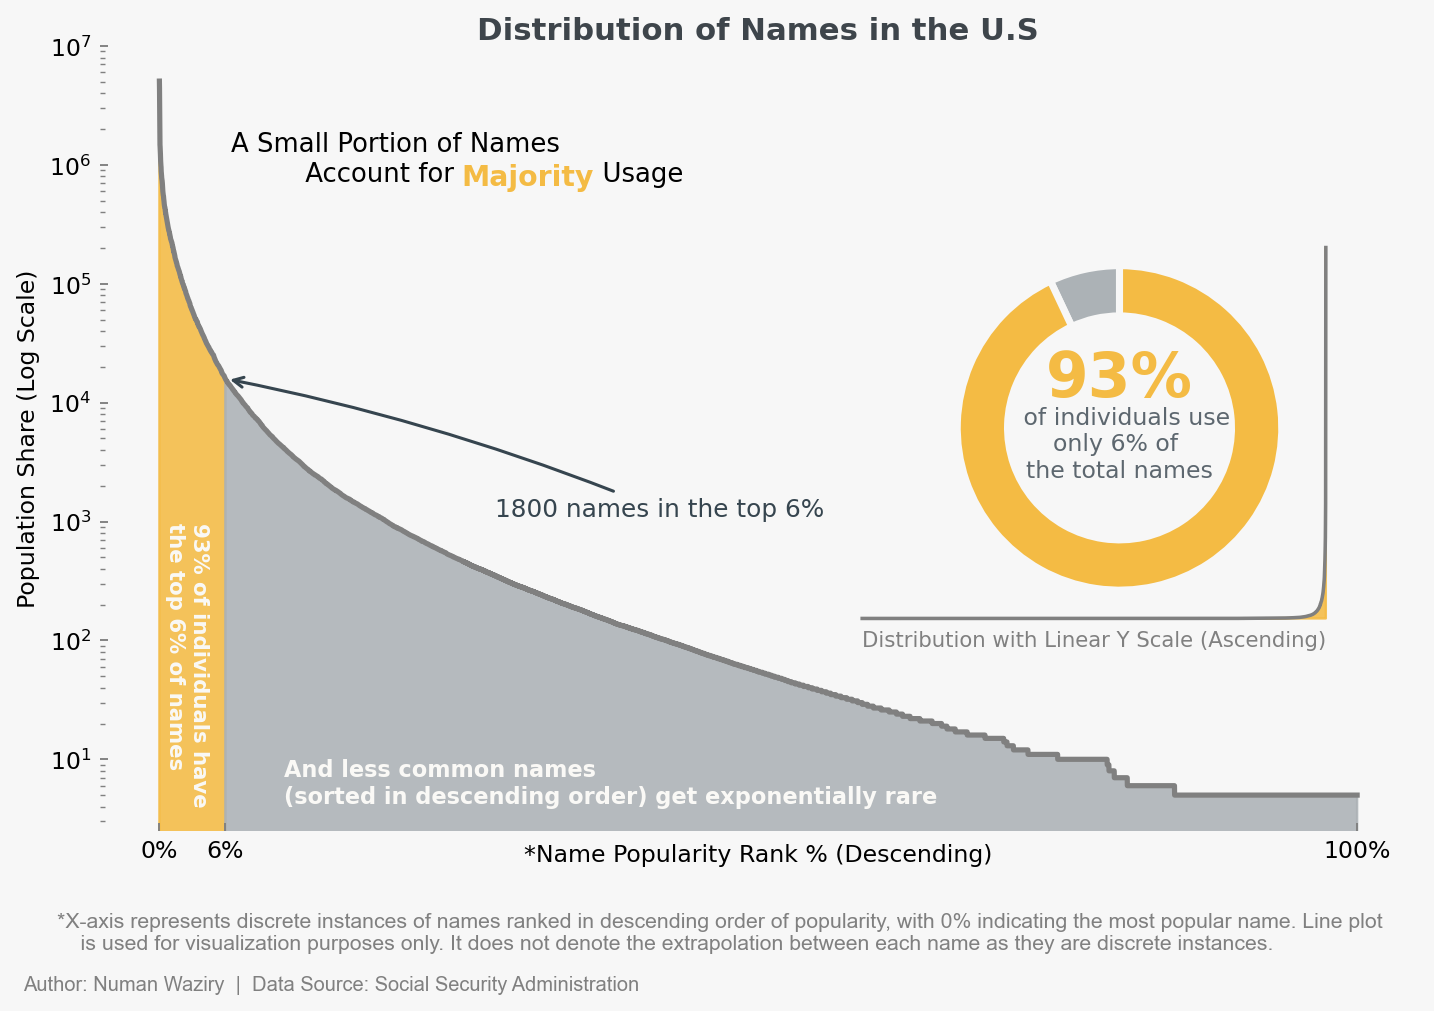

In [46]:
def transform_data(df):
    # Calculate the sum of births per name and sort in descending order
    return df.groupby("Name").Births.sum().sort_values(ascending=False)

def plot_line(ax, data, topN, names_percentage, accent_color):
    # Set the background color and plot the data as a line plot
    ax.set_facecolor('none')
    data.plot.line(ax=ax, lw=2.2, color='grey', ylabel='Population Share (Log Scale)')
    
    # Customize the X and Y axis labels
    ax.set_xlabel("*Name Popularity Rank % (Descending)", labelpad=-8)
    line_data = ax.lines[0].get_data()
    ax.set_xticks([0, topN, line_data[0][-1]], ["0%", f'{names_percentage}%', "100%"])
    
    # Set Y-axis scale to logarithmic
    ax.set_yscale("log")
    
    # Adjust tick parameters and remove spines
    ax.tick_params(axis='both', which='both', color='grey', direction='in')
    sns.despine(left=True, bottom=True, ax=ax)
    
    # Fill area below and above the specified topN rank with different colors
    ax.fill_between(line_data[0], line_data[1], where=(line_data[0] <= topN), alpha=0.88, color=accent_color)
    ax.fill_between(line_data[0], line_data[1], where=(line_data[0] > topN), alpha=0.88, color="#ACB2B6")

def plot_pie(ax, percentage_of_population, accent_color):
    # Define sizes and colors for the pie chart
    sizes = [100 - percentage_of_population, percentage_of_population]
    colors = ['#ACB2B6', accent_color]
    
    # Plot the pie chart with specified properties
    ax.pie(sizes, colors=colors, startangle=90, wedgeprops={"edgecolor": "#F7F7F7", 'linewidth': 3, "width": 0.31})
    
    # Set the aspect ratio of the pie chart to be equal
    ax.axis('equal')

def plot_small_line(ax, data, line_data, topN, accent_color):
    # Plotting a small line using Seaborn's lineplot function
    sns.lineplot(data=data, x=line_data[0], y=line_data[1], ax=ax, color='grey')
    
    # Setting ticks to empty lists, since only the trend is important here
    ax.set(yticks=[], xticks=[])
    
    # Setting the label for the x-axis
    ax.set_xlabel("Distribution with Linear Y Scale (Ascending)", size=9, labelpad=-3, color="grey")
    
    # Removing spines from the plot
    sns.despine(ax=ax, left=True, bottom=True)
    
    # Filling the area under the curve for topN names
    ax.fill_between(line_data[0], line_data[1], alpha=0.88,
                    color=np.where(line_data[0] <= topN, accent_color, "#ACB2B6"))
    
    # Inverting the x-axis for ascending trend
    ax.invert_xaxis()
    
def annotate_plots(ax, ax2, ax3, topN, names_percentage, percentage_of_population,line_data,accent_color,title):
    # Setting the main title and subtitle
    subtitle = "A Small Portion of Names\n         Account for                  Usage"
    ax.set_title(title, fontsize=13, fontweight='bold', pad=0, color="#3E454B")
    ax.text(0.1, 0.855, subtitle, fontsize=11, fontweight='normal',
            ha='left', va='center', transform=ax.transAxes)

    # Adding text annotations and highlighting certain information
    ax.text(0.275, 0.85, "Majority", fontsize=12, fontweight='bold',
            ha='left', va='top', transform=ax.transAxes, color=accent_color)
    ax.text(0.14, 0.06, "And less common names\n(sorted in descending order) get exponentially rare",
            fontsize=9.5, fontweight='bold',
            ha='left', va='center', transform=ax.transAxes, color='#FAF9F6')
    ax.text(0.05, 0.03, f"{percentage_of_population}% of individuals have\nthe top {names_percentage}% of names",
            fontsize=9, fontweight='bold',
            ha='left', va='bottom', transform=ax.transAxes, color='#FAF9F6', rotation=-90)

    ax2.text(0, 0.3, f"{percentage_of_population}%", ha='center', va='center', size=26, weight='bold', color=accent_color)
    ax2.text(0, -0.1, f"   of individuals use \nonly {names_percentage}% of \nthe total names",
             ha='center', va='center', size=10, color='#5D676F')

    # Additional notes
    note = """*X-axis represents discrete instances of names ranked in descending order of popularity, with 0% indicating the most popular name. Line plot 
    is used for visualization purposes only. It does not denote the extrapolation between each name as they are discrete instances."""
    ax.text(0.1, -0.01, note, transform=ax.figure.transFigure,
            ha='left', va='bottom', fontsize=9, color='grey', fontname="Arial")

    # Adding an annotation with an arrow to highlight specific information
    ax.annotate(f'{topN} names in the top {names_percentage}%',
                xy=(topN, line_data[1][topN]), xycoords='data', size=10.5, color="#36454F",
                xytext=(0.3, 0.4), textcoords='axes fraction', ha='left',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.05", lw=1.3, color="#36454F"))

    # Footer information about the author and data source
    plt.gcf().text(0.08, -0.05, "Author: Numan Waziry  |  Data Source: Social Security Administration", fontname="Arial",
                   ha='left', va='bottom', fontsize=8.5, color='grey')
    
def create_plot(df, topN=1800, accent_color='#F4BB44', title="Distribution of Names in the U.S"):
    # Data transformation and calculation
    data = transform_data(df)
    names_percentage = int(round((topN / len(data)), 2) * 100)
    percentage_of_population = int((data.nlargest(topN).sum() / data.sum()).round(2) * 100)
    
    # Setting up the canvas and subplots
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='#F7F7F7', dpi=170)
    plot_line(ax, data, topN, names_percentage, accent_color)  
    
    # Adding axes for additional visualizations
    ax2 = fig.add_axes([0.55, 0.33, 0.35, 0.35])
    plot_pie(ax2, percentage_of_population, accent_color)
    
    ax3 = fig.add_axes([0.56, 0.3, 0.3, 0.4], facecolor='none')
    plot_small_line(ax3, data, ax.lines[0].get_data(), topN, accent_color)
    
    # Annotating and adding descriptions to the plot
    annotate_plots(ax, ax2, ax3, topN, names_percentage, percentage_of_population, 
                   ax.lines[0].get_data(), accent_color, title)
    
create_plot(df,1800)

## distribution - 2

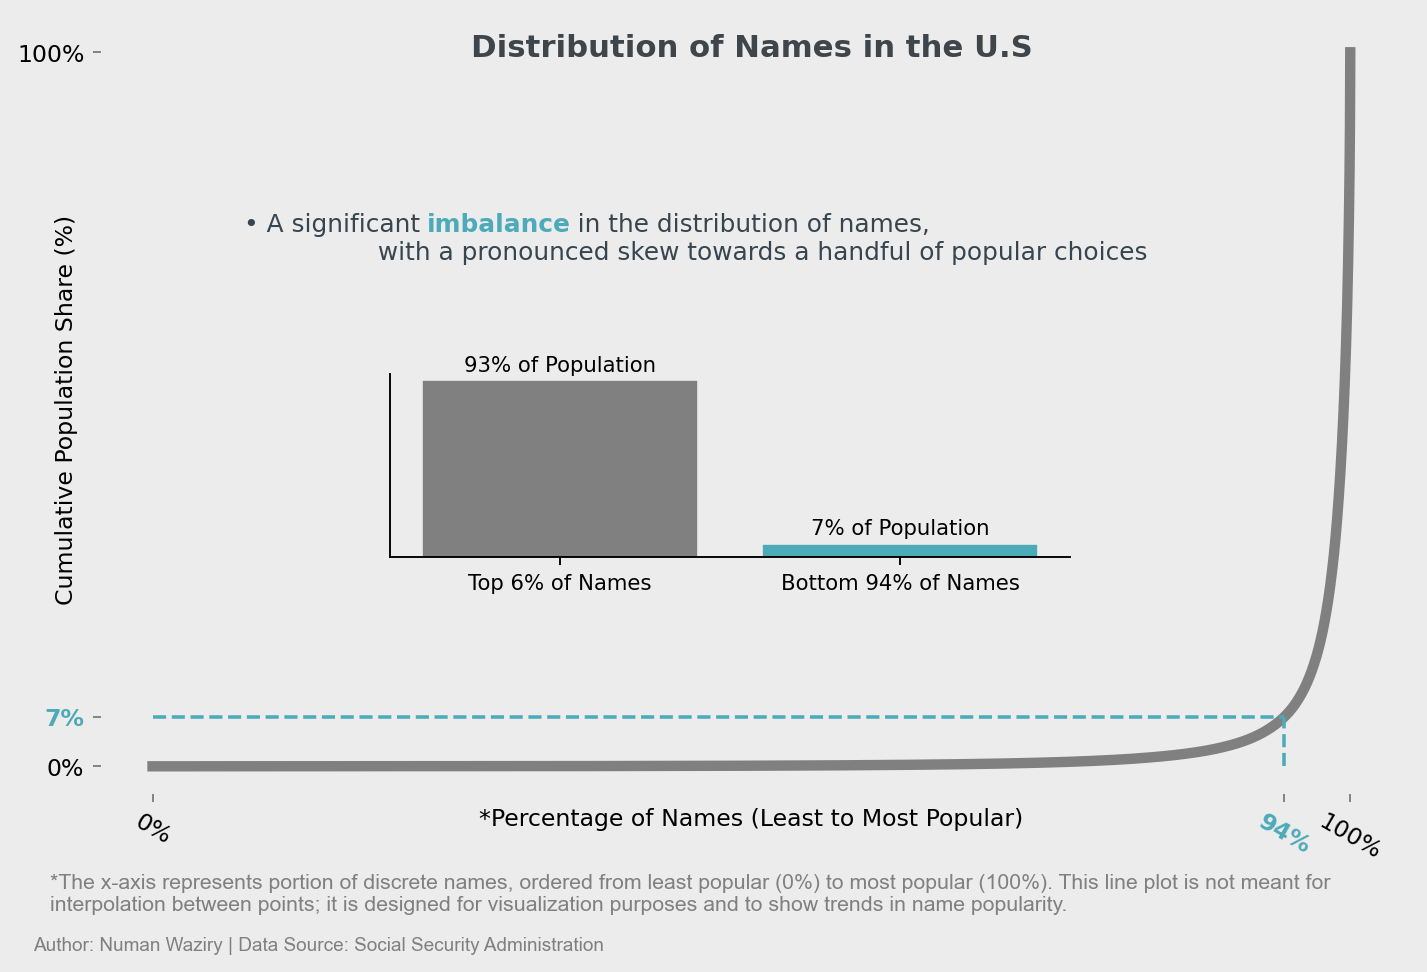

In [45]:
def transform_data(df):
    """
    Calculate the sum of births per name and sort in descending order.
    """
    return df.groupby("Name").Births.sum().sort_values(ascending=False)


def plot_cumulative_line(ax, data, top_names_count, top_names_percentage, population_percentage, accent_color):
    """
    Plot cumulative line chart for name distribution and population share.
    """
    
    # Set the background color and plot the data as a line plot
    ax.set_facecolor('none')
    sns.despine(left=True, bottom=True, ax=ax)
    
    # Plotting the cumulative sum of names
    data.sort_values().cumsum().plot(color='grey', ax=ax, lw=4.4)
    
    ax.set_xlabel("*Percentage of Names (Least to Most Popular)", labelpad=-24)
    ax.set_ylabel("Cumulative Population Share (%)", labelpad=-26)
    
    # Styling ticks and labels
    plt.setp([ax.get_xticklabels()[1], ax.get_yticklabels()[1]], color=accent_color, weight='bold')
    
    x, y = ax.lines[0].get_data()
    bottom_names_count = x[-1] - top_names_count
    
    # Setting custom ticks and grid lines
    ax.set_xticks([x[0], bottom_names_count, x[-1]], ['0%', f'{100 - top_names_percentage}%', "100%"], rotation=-30)
    ax.set_yticks([y[0], y[bottom_names_count], y[-1]], ['0%', f'{100 - population_percentage}%', "100%"])
    
    # Adding dashed lines for emphasis
    ax.hlines(y[bottom_names_count], xmin=0, xmax=bottom_names_count, ls='dashed', color=accent_color)
    ax.vlines(bottom_names_count, ymin=0, ymax=y[bottom_names_count], ls='dashed', color=accent_color)
    
    # Adjusting tick parameters
    ax.tick_params(axis='both', direction='in', color="grey")

def plot_population_bar(ax, data, top_names_percentage, population_percentage, accent_color):
    """
    Plot bar chart for top and bottom percentage of names and population distribution.
    """
    ax.set(xticks=[], yticks=[])
    plt.tick_params(axis='x', labelsize=9)
    
    # Selecting top and bottom data for bar plot
    top_names_threshold = (1 - (100 - top_names_percentage) / 100)
    top_names_data = data.nlargest(int(len(data) * top_names_threshold))
    bottom_names_data = data.nsmallest(len(data) - int(len(data) * top_names_threshold))
    
    # Creating a DataFrame for bar plot
    population_distribution = pd.Series([(top_names_data.sum() / data.sum()) * 100, 
                                         (bottom_names_data.sum() / data.sum()) * 100],
                                        [f"Top {top_names_percentage}% of Names", f"Bottom {100 - top_names_percentage}% of Names"])
    
    sns.despine(ax=ax)
    sns.barplot(pd.DataFrame(population_distribution).T, ax=ax)
    
    # Adding labels and adjusting colors
    for i, patch in enumerate(ax.patches):
        x = patch.get_x() + (patch.get_width() / 2)
        y = patch.get_height()
        label = f"{population_percentage}% of Population" if i == 0 else f"{100 - population_percentage}% of Population"
        color = "grey" if i == 0 else accent_color
        
        ax.text(x, y + 6, label, ha='center', size=9)
        patch.set_color(color)

def annotate_plots(ax, title, accent_color):
    """
    Annotate the plots with additional information and title.  
    """
    ax.text(2.5e3, 2.5e8, "• A significant                    in the distribution of names,\n     "\
            "            with a pronounced skew towards a handful of popular choices",
            fontsize=10.5, ha='left', va='top', color="#36454F")

    ax.text(7.5e3, 2.5e8, "imbalance", fontsize=10.5, ha='left', va='top', color=accent_color, weight='bold')

    ax.text(0.5, 0.96, title, size=13, weight='bold', color="#3E454B",
            ha='center', va='center', transform=ax.transAxes)

    note = """*The x-axis represents portion of discrete names, ordered from least popular (0%) to most popular (100%). This line plot is not meant for \ninterpolation between points; it is designed for visualization purposes and to show trends in name popularity."""
    ax.text(0.1, 0.00, note, transform=ax.figure.transFigure, ha='left', va='bottom', fontsize=9, color='grey', fontname="Arial")
    
    plt.gcf().text(0.09, -0.04, "Author: Numan Waziry | Data Source: Social Security Administration", fontname="Arial",
                  ha='left', va='bottom', fontsize=8, color='grey')

def create_plot(df, accent_color="#4DAAB9", title="Distribution of Names in the U.S"):
    """
    Create the main plot with the specified data and settings.
    """
    name_data = transform_data(df)
    top_names_count = 1800
    top_names_percentage = int(round((top_names_count / len(name_data)), 2) * 100)
    population_percentage = int((name_data.nlargest(top_names_count).sum() / name_data.sum()).round(2) * 100)
    
    fig, ax = plt.subplots(figsize=(10, 6), facecolor="#ECECEC", dpi=170)
    plot_cumulative_line(ax, name_data, top_names_count, top_names_percentage, population_percentage, accent_color)
    
    ax2 = fig.add_axes([0.3, 0.35, 0.4, 0.18], facecolor='none')
    plot_population_bar(ax2, name_data, top_names_percentage, population_percentage, accent_color)
    annotate_plots(ax, title, accent_color)
    
    return fig


create_plot(df);

## Log-Log Plot <span style="color: #ff6347;">Power Law Distribution</span>

In [19]:
def transform_data(df):
    return df.groupby("Name").Births.sum().sort_values(ascending=False)

def calculate_empirical_pdf(data):
    # Calculate the empirical PDF using the data
    bins = np.logspace(np.log10(data.min()), np.log10(data.max()), 100)
    counts, edges = np.histogram(data, bins=bins, density=True)
    x = (edges[:-1] + edges[1:]) / 2
    return counts, x

def fit_power_law(data,x):
    # Fit the power law distribution to the data
    alpha = 1 + len(data) / np.sum(np.log(data / data.min()))
    y = x ** -alpha
    return alpha, y

def plot_log_log(counts, y, alpha,accent_color):
    fig, ax = plt.subplots(figsize=(10, 6), facecolor="#ECECEC",dpi=160)
    ax.set_title("Log-Log Plot", pad=-10, weight='bold', size=13, color='#3E454B')
    ax.scatter(counts, y, color=accent_color, zorder=2)
    ax.plot([-1, 1], [-1, 1], color='grey', label='45-Degree Line', lw=2.2, zorder=1, alpha=0.6)
    ax.set(xscale="log", yscale="log", xlabel="Empirical (Names) Probability Density",
           ylabel="Power-Law Probability Density", xlim=(1e-11, 1e-0), ylim=(1e-11, 1e-0), facecolor="none")
    sns.despine(ax=ax)
    ax.grid(zorder=0, color="#D3D3D3")
    ax.text(1e-5, 1e-10, rf"Fitted power-law parameter $\alpha$ = {round(alpha,2)}",
            fontsize=11, bbox=dict(facecolor='#f9f9f9', edgecolor='black', boxstyle='round,pad=0.3'))
    fig.text(0.07, -0.02, "Data Source: Social Security Administration  |  Author: Numan Waziry",fontname="Arial",
            ha='left', va='bottom', fontsize=9, color='grey')

    return fig

def create_plot(df,accent_color="#4DAAB9"):
    data = transform_data(df)
    counts, x = calculate_empirical_pdf(data)
    alpha, y = fit_power_law(data,x)
    return plot_log_log(counts, y, alpha,accent_color)

create_plot(df);

## Overall Birth Trend

In [28]:
def transform_data(df):
    # Calculate rolling mean and last 40 years' data
    rolling_mean = df.groupby("Year").sum(numeric_only=True).rolling(5).mean()
    last40_years = df.groupby("Year").sum(numeric_only=True).loc['1980':]
    return rolling_mean, last40_years

def plot_data(rolling_mean):
    # Create plot for rolling mean data
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='#F7F7F7', dpi=180)
    ax.set_facecolor("none")
    rolling_mean.plot(lw=4, ax=ax, path_effects=[path_effects.SimpleLineShadow(shadow_color='black', linewidth=4, alpha=0.23), path_effects.Normal()])
    sns.despine(left=True, ax=ax)
    ax.legend().remove()
    fig.tight_layout()

    # Format y-axis labels to million units
    def million_formatter(x, pos):
        return "%.1fM" % (x / 1E6)
    ax.yaxis.set_major_formatter(million_formatter)
    ax.tick_params(which='major', axis="y", width=0, colors="#36454F", labelsize=10)
    ax.tick_params(which='minor', axis="x", width=0, colors="#36454F")
    return fig, ax

def annotate_plot(ax, rolling_mean):
    # Annotations for the plot
    path_effect = [path_effects.withStroke(linewidth=6, foreground="#F7F7F7")]
    plt.text(50, rolling_mean.iloc[-1] + 1.18e6, "US Birth Trend, 1910-2022", va="center", size=17, ha="right", fontname="Arial", weight='bold', color="#3E454B", path_effects=path_effect)
    plt.text(22, rolling_mean.iloc[-1] + 1e6, "Five-Year Moving Average", va="center", size=14, fontname="Arial", color="#5D676F", path_effects=path_effect)
    plt.text(53, rolling_mean.iloc[-1], "Births", color="#1f77b4", weight="bold", va="center", size=11)
    
    # Annotations with details
    ax.annotate(r"$\bf{'Baby^ Booms'}$" +
                " The war’s end, \nfollowed by a sustained period \n"\
                "of economic prosperity (the 1950s \nand early 1960s), was accompanied \nby a surge in population.",
                xy=(-10, rolling_mean.max()), xycoords='data', size=10.5, color="#36454F",
                xytext=(0.2, 0.1), textcoords='axes fraction', ha='left',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.15", lw=1.5, color="#36454F"),
                path_effects=path_effect)
    
    ax.annotate("2020 has the lowest number\n" + r"of births in the past $\bf{40^ Years}$",
                xy=(50, rolling_mean.loc["1980":].min()), xycoords='data', size=10.5, color="#36454F",
                xytext=(0.7, 0.5), textcoords='axes fraction', ha='left',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2", lw=1.5, color="#36454F"),
                path_effects=path_effect)
    
    plt.gcf().text(0.012, 0, "Data Source: Social Security Administration  |  Author: Numan Waziry", transform=ax.figure.transFigure, fontname="Arial",
                   ha='left', va='bottom', fontsize=9, color='grey')

    ax.grid(axis="y", color='#D3D3D3', alpha=0.6)

def plot_secondary_axes(last40_years, fig):
    # Plot secondary axes for last 40 years' data
    ax2 = fig.add_axes([0.67, 0.215, 0.3, 0.3])
    sns.lineplot(data=last40_years, ax=ax2, legend=False)
    ax2.set_xticks(ax2.get_xticks()[1::2], ax2.get_xticklabels()[1::2], size=9)
    ax2.set(ylabel="", xlabel="", yticks=[], facecolor="#F7F7F7")
    ax2.spines["top"].set_visible(False)
    ax2.spines[:].set_color("#5D676F")
    ax2.tick_params(axis="x", color="#5D676F")
    ax2.get_xticklabels()[-1].set_color('#1f77b4')
    ax2.get_xticklabels()[-1].set_weight('bold')
    return fig, ax2

def create_plot(df):
    # Generate plot with transformed data and annotations
    rolling_mean, last40_years = transform_data(df)
    fig, ax = plot_data(rolling_mean)
    annotate_plot(ax, rolling_mean)
    plot_secondary_axes(last40_years, fig)
    return fig

create_plot(df);


## States Ranking

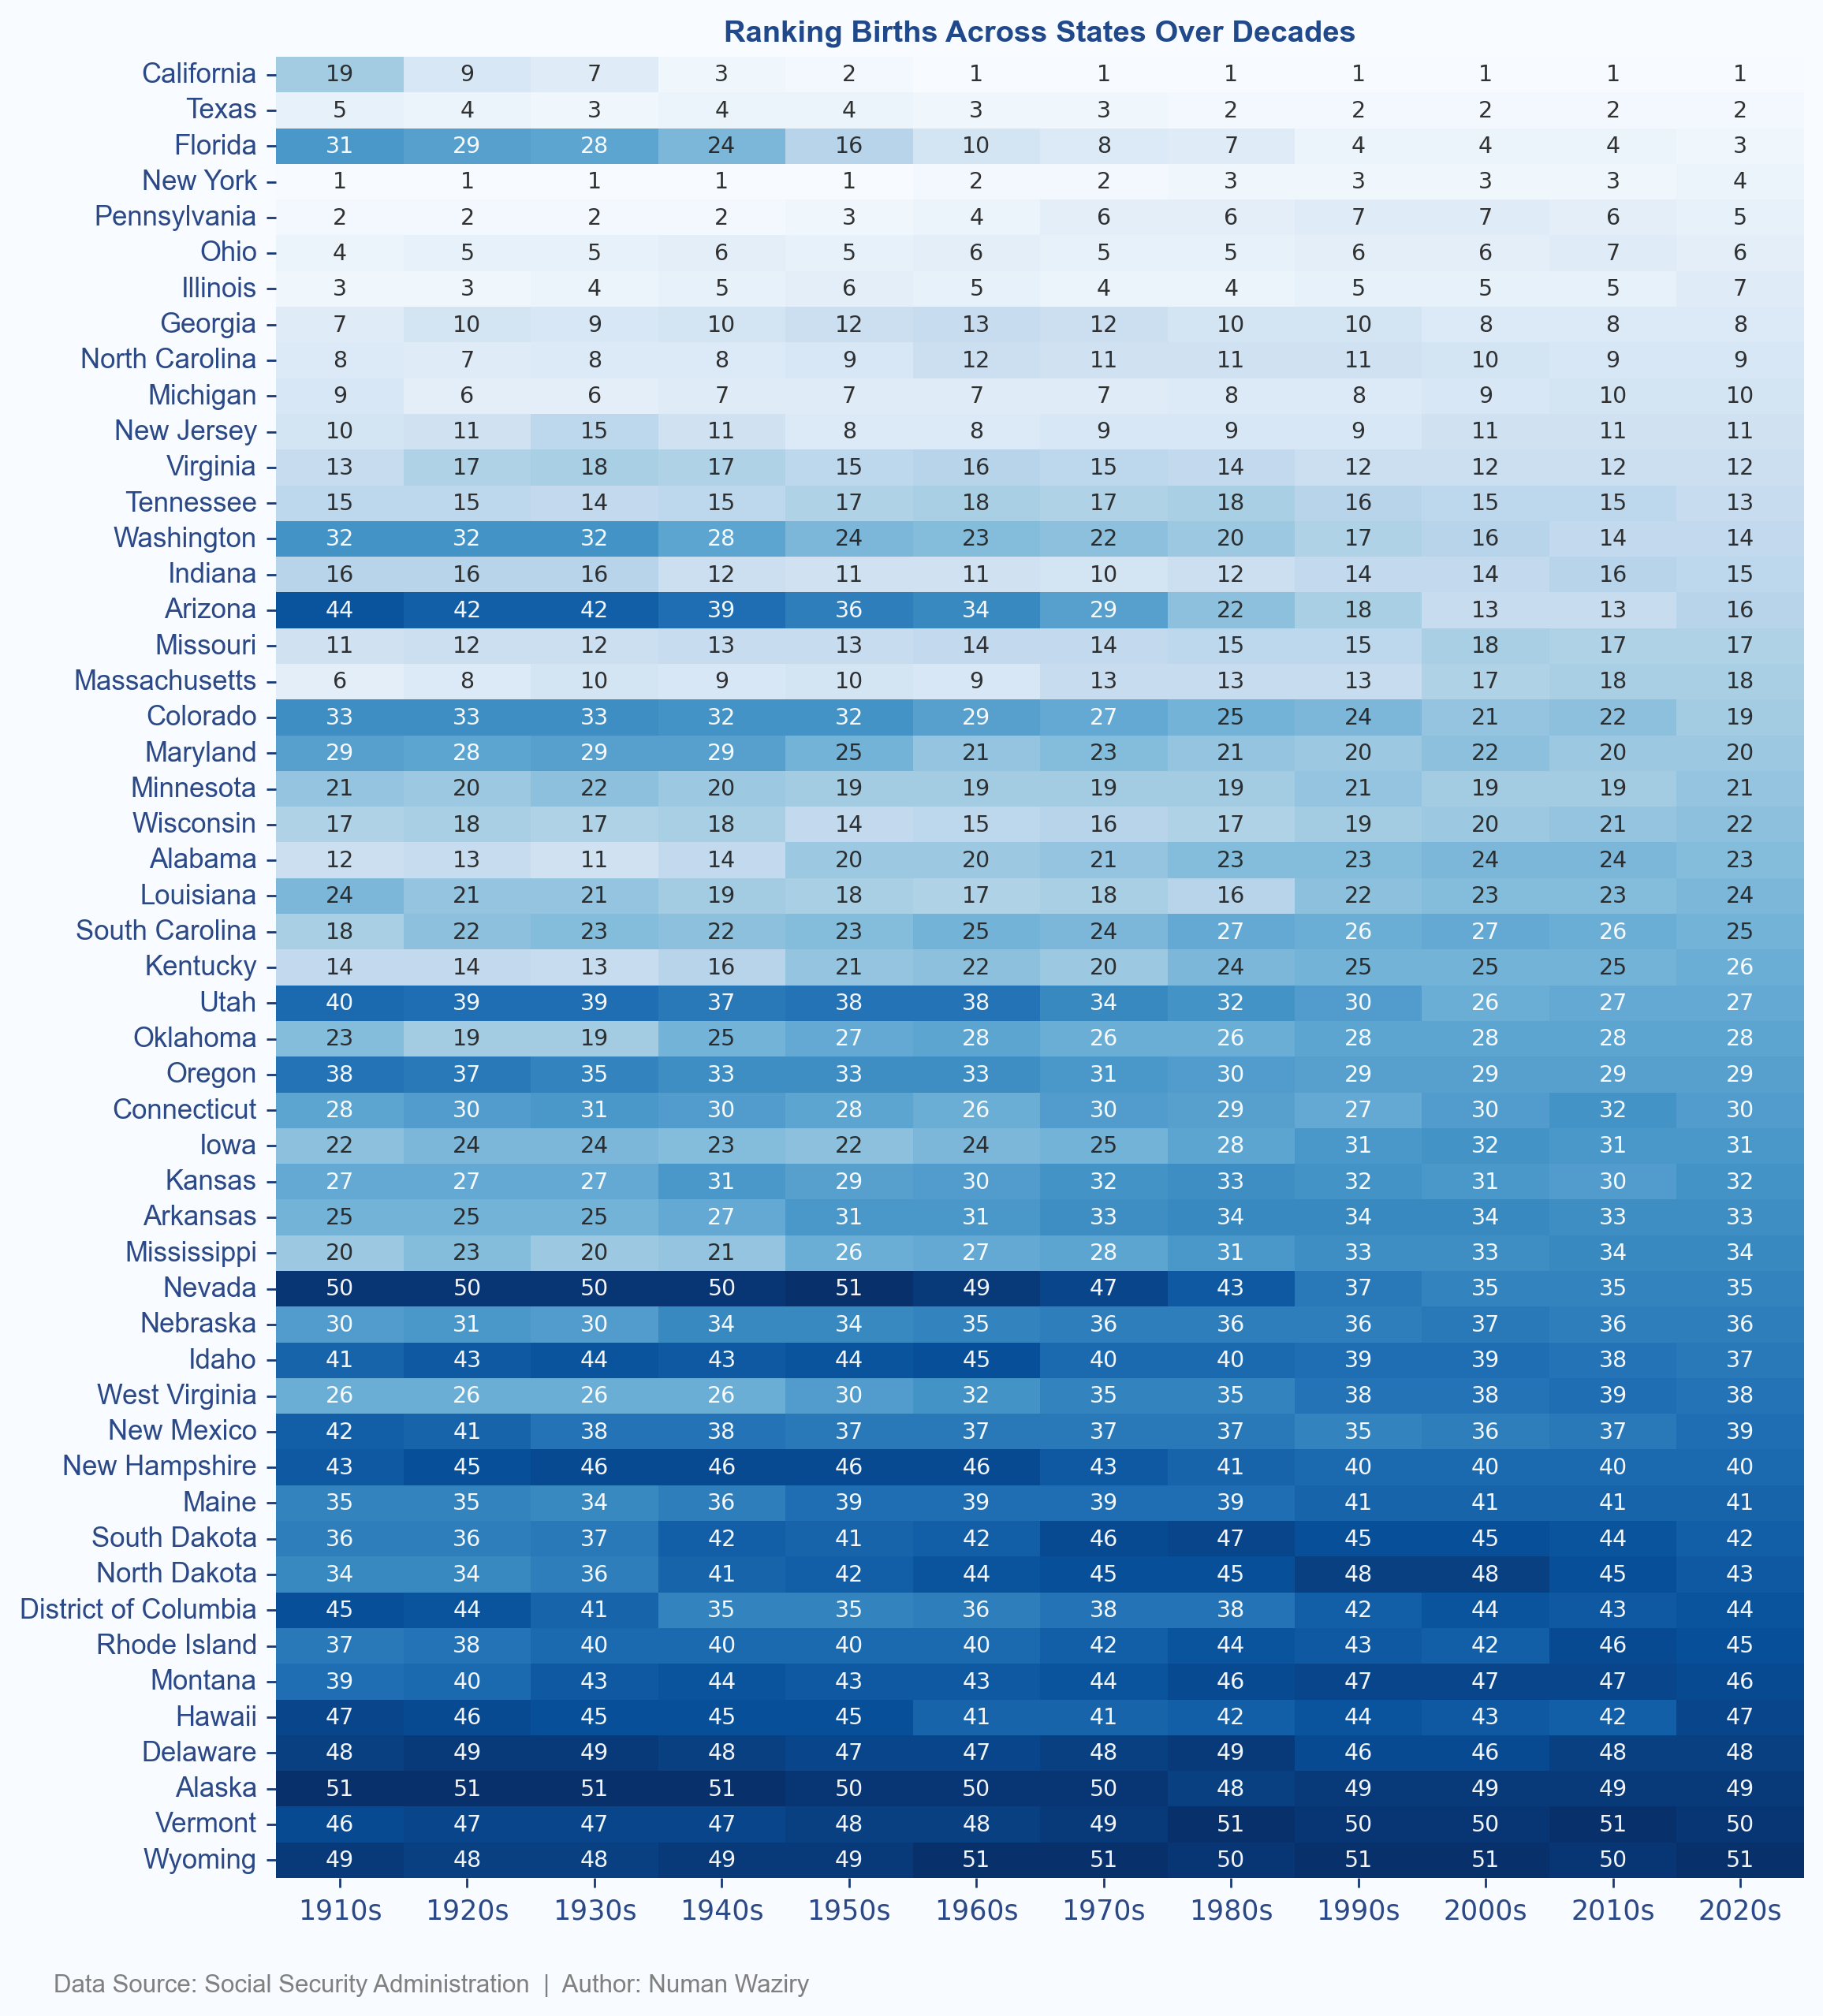

In [21]:
def transform_data(df):
    return (df.groupby(["State", pd.Grouper(key="Year", freq="10AS")]).Births.sum().unstack(0).rank(axis=1,ascending=False)
              .T.rename(lambda x: f'{x.year}s', axis=1).sort_values("2020s"))

def plot_heatmap(ranked):
    fig, ax = plt.subplots(figsize=(10, 12), dpi=250, facecolor="#F8FBFF")
    sns.heatmap(ranked, annot=True, ax=ax, cbar=False, cmap="Blues", annot_kws={"alpha": 0.95, "size": 8.2})
    plt.title("Ranking Births Across States Over Decades",weight='bold',size=11,color='#20498C',fontname="Arial")
    ax.set(xlabel="", ylabel="",facecolor="none")
    ax.tick_params(colors='#193976', labelcolor='#2B4887')
    ax.set_yticklabels(ax.get_yticklabels(),fontname='Arial')
    fig.text(0.012,0.06, "Data Source: Social Security Administration  |  Author: Numan Waziry", transform=ax.figure.transFigure,fontname="Arial",
        ha='left', va='bottom', fontsize=9, color='grey')
    return fig,ax

def create_plot(df):
    ranked = transform_data(df)
    fig,ax = plot_heatmap(ranked)
    return fig
    
create_plot(df);

## Birth Rate flactuations Throughout the Years

In [22]:
def transform_data(df,topN):
    ranks = df.groupby(["State", pd.Grouper(key="Year", freq="10AS")]).Births.sum().unstack(0).rank(axis=1)
    top_changes = (ranks.apply(lambda x: x[0]-x[-1]).abs().nlargest(topN))
    return ranks, top_changes

def plot_birth_rate_rankings(n, ranked):
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6) ,facecolor='#f9fbfc',dpi=250)
    fig.suptitle(f'Birth Rate Rankings: Top 6 States with Significant Changes', fontsize=14,weight="bold",color='#3E454B')
    for i, (idx, data) in enumerate(n.items()):
        ax = axes.flatten()[i]
        ranked[idx].plot(ax=ax, label=idx, color='#0b53c1', xlabel="", marker='o',
                         markersize=6, markerfacecolor='white', zorder=60, linewidth=2.2)
        ranked.drop(idx, axis=1).plot(ax=ax, color='#BFBFBF', xlabel="", zorder=3, lw=1.2)

        ax.legend().remove()
        sns.despine(ax=ax)
        ax.set(yticks=[], xticks=list(range(-60, 60, 10)),facecolor="none",frame_on=False)
        ax.set_xticklabels(
            ["10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s", "00s", "10s", "20s"],
            rotation=-45, ha='left', size=9
        )
        ax.tick_params(bottom=False, which='both', pad=-7, left=False)

        y1, y2 = ranked[idx].iloc[[0, -1]]
        ax.text(-66, y1, "#" + str(int(52 - y1)), rotation=90, size=9)
        ax.text(52, y2+5, "#" + str(int(52 - y2)) + f' | {int(data)} ranks', rotation=-84, va='top',weight='bold', size=9,color="#1f77b4")
        ax.text(45, 5, str(i + 1) + ". " + idx, color="#1f77b4", ha='right', weight='bold',
                fontsize=11, bbox=dict(facecolor='#f9f9f9', edgecolor='black', boxstyle='round,pad=0.4'))
    
    fig.text(0.015, -0.015, "Data Source: Social Security Administration  |  Author: Numan Waziry",fontname="Arial",
            ha='left', va='bottom', fontsize=9, color='grey')
    fig.tight_layout()
    return fig, axes

def create_plot(df,topN=6):
    ranked,top=transform_data(df,topN)
    fig,ax=plot_birth_rate_rankings(top, ranked)
    return fig

create_plot(df);

## Overall Top 10 States with highest Births

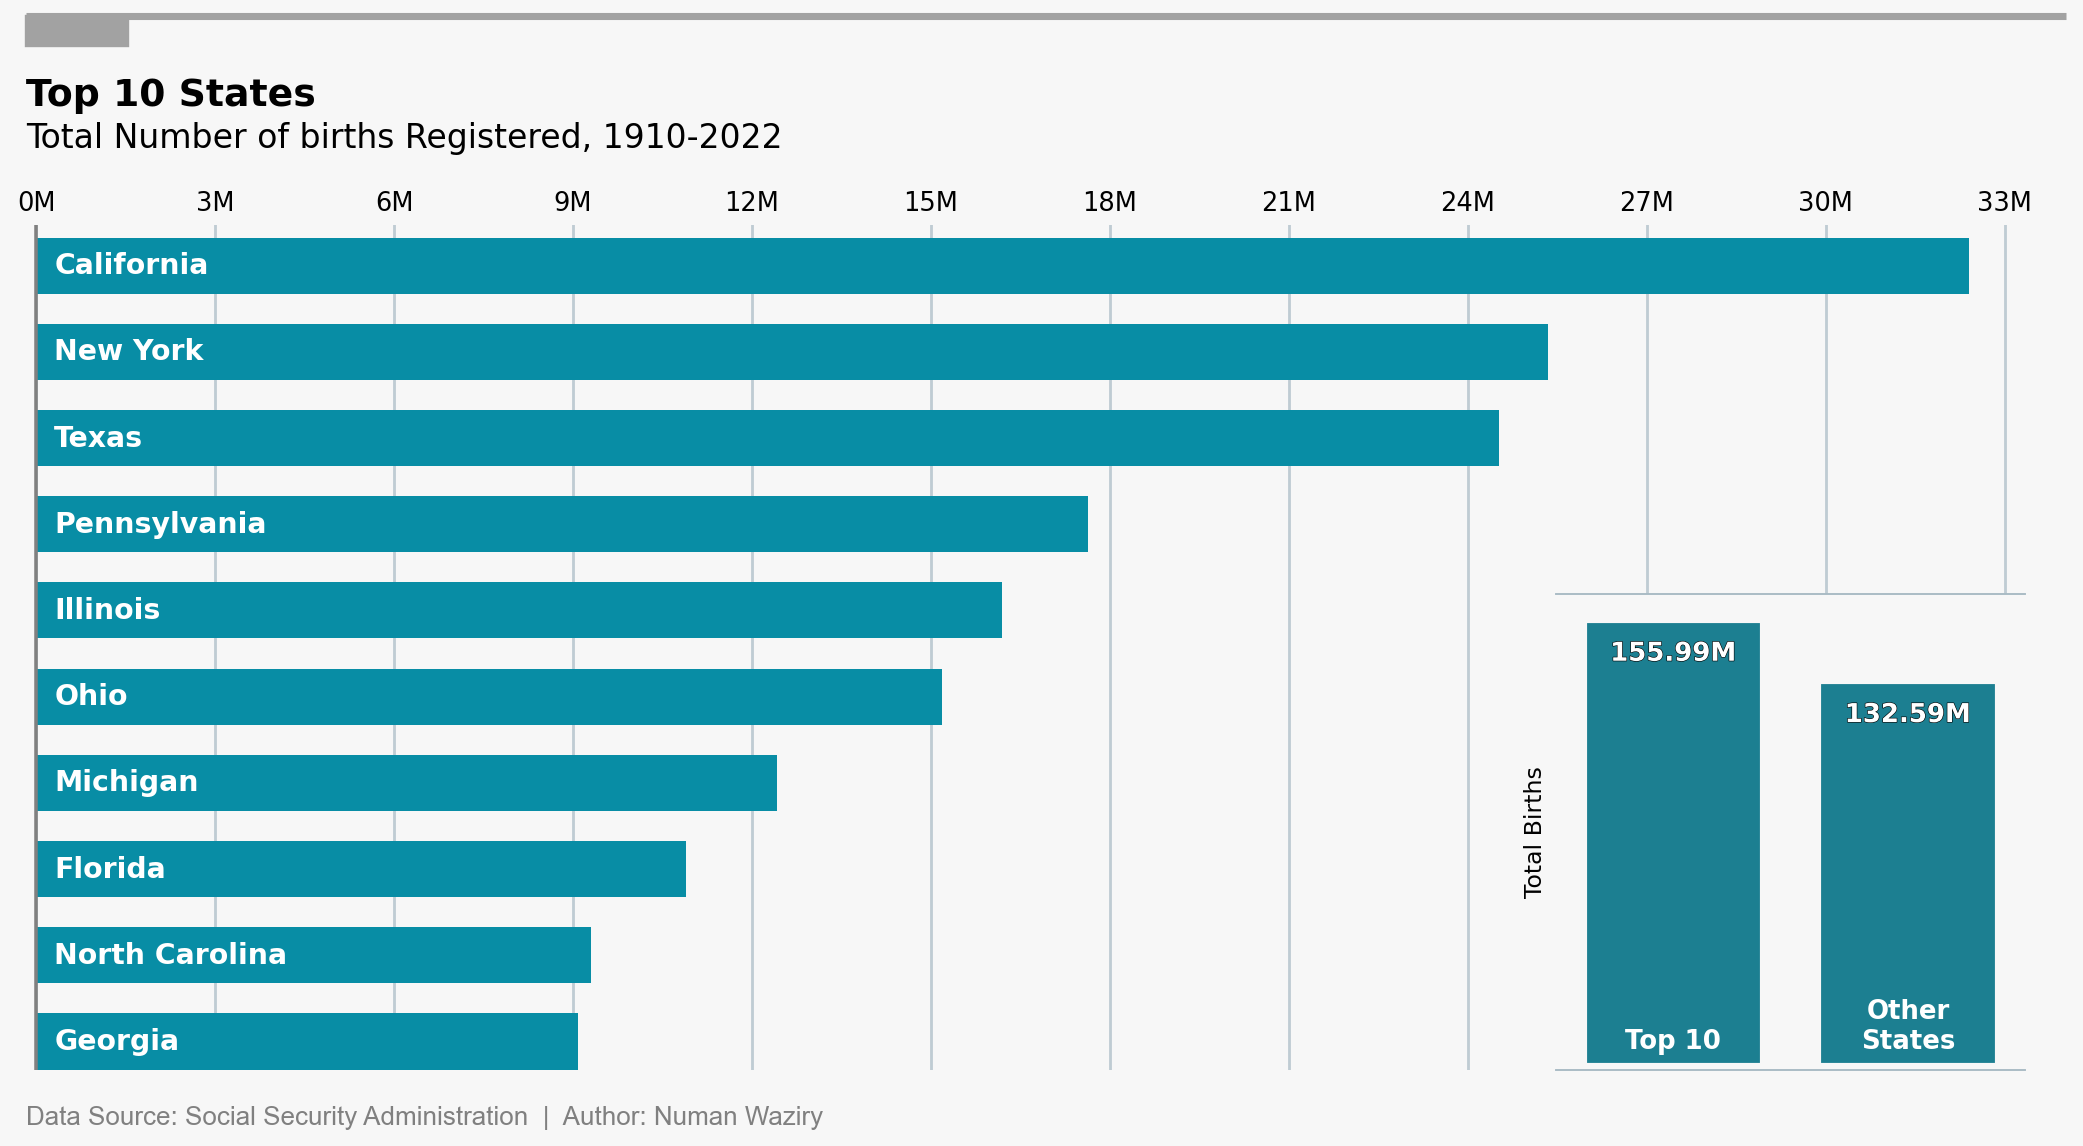

In [23]:
def transform_data(df, n=10):
    topN = df.groupby('State').Births.sum().nlargest(n).sort_values()
    aggregated = (df.groupby('State').Births.sum().to_frame().reset_index()
        .assign(State = lambda df:df.State.mask(df.State.isin(df.nlargest(n,"Births").State),f"Top {n}")
                .where(df.State.isin(df.nlargest(n,"Births").State),"Other\nStates")).groupby("State").sum()
        .sort_values("Births",ascending=False))
    return topN, aggregated

def plot_bar(data):
    BLUE, BLACK, GREY = "#076fa2", "#202020", "#a2a2a2"
    fig, ax = plt.subplots(figsize=(12, 7),facecolor='#F7F7F7',dpi=170)
    thickness = 0.65
    ax.barh(data.index, data, height=0.65, align="edge", color="#088da5");
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=12))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000000:.0f}M'))
    ax.set(axisbelow=True, ylim=(0, len(data) - 0.2),facecolor='none')
    ax.grid(axis = "x", color="#A8BAC4", lw=1.2,alpha=0.7)
    sns.despine(ax=ax,bottom=True)
    ax.spines["left"].set(lw=1.5, capstyle="butt", color='grey')
    ax.tick_params(labeltop=True,labelbottom=False,length=0,labelsize=10.9)
    ax.yaxis.set_visible(False)

    # Add line and rectangle on top.
    fig.add_artist(lines.Line2D([0, 1], [0.985, 0.985], lw=3, color=GREY, solid_capstyle="butt"))
    fig.add_artist(patches.Rectangle((0, 0.96), 0.05, 0.025, color=GREY))

    for i, p in enumerate(ax.patches):
        plt.text(0 + 3e5, p.get_y() + thickness/2, data.index[i], va="center", color="white", size=12, weight='bold')

    fig.text(0, 0.91, "Top 10 States", fontsize=16, fontweight="bold")

    fig.text(0, 0.875, "Total Number of births Registered, 1910-2022", fontsize=14)
    fig.subplots_adjust(left=0.005, right=1, top=0.81, bottom=0.1)
    return fig, ax
    
def plot_secondary_bar(data,fig):
    ax2=fig.add_axes([0.75,0.1,0.23,0.4])
    sns.barplot(data.T,color="#088da5",width=0.8,edgecolor="#F7F7F7",linewidth=6)
    # sns.despine(left=True,ax=ax2)
    ax2.spines["bottom"].set_color('grey')
    ax2.tick_params(left=False,bottom=False,labelbottom=False,labelleft=False)
    ax2.set(xlabel="", ylabel="Total Births", facecolor="#F7F7F7")
    sns.despine(ax=ax2,top=False,left=True)
    ax2.spines[:].set_color("#A8BAC4")

    for i,patch in enumerate(ax2.patches):
        x= patch.get_width()/2 + patch.get_x()
        pad=8e6
        y=patch.get_height()-1.7e7
        path_effect=[path_effects.withStroke(linewidth=0.5, foreground="black")]
        ax2.text(x,pad,data.index[i],color="white",ha="center",size=11,weight="bold")
        ax2.text(x,y,str(round(y/1e6,2))+"M",color="white",ha="center",size=11,path_effects=path_effect,weight="bold")
    
def create_plot(df):
    top10, aggregated = transform_data(df)
    fig,ax = plot_bar(top10)
    fig.text(0, 0.05, "Data Source: Social Security Administration  |  Author: Numan Waziry",fontname="Arial",
            ha='left', va='bottom', fontsize=11, color='grey')
    plot_secondary_bar(aggregated,fig)
    return fig
    
create_plot(df);

## Top 5 names every 3 decades

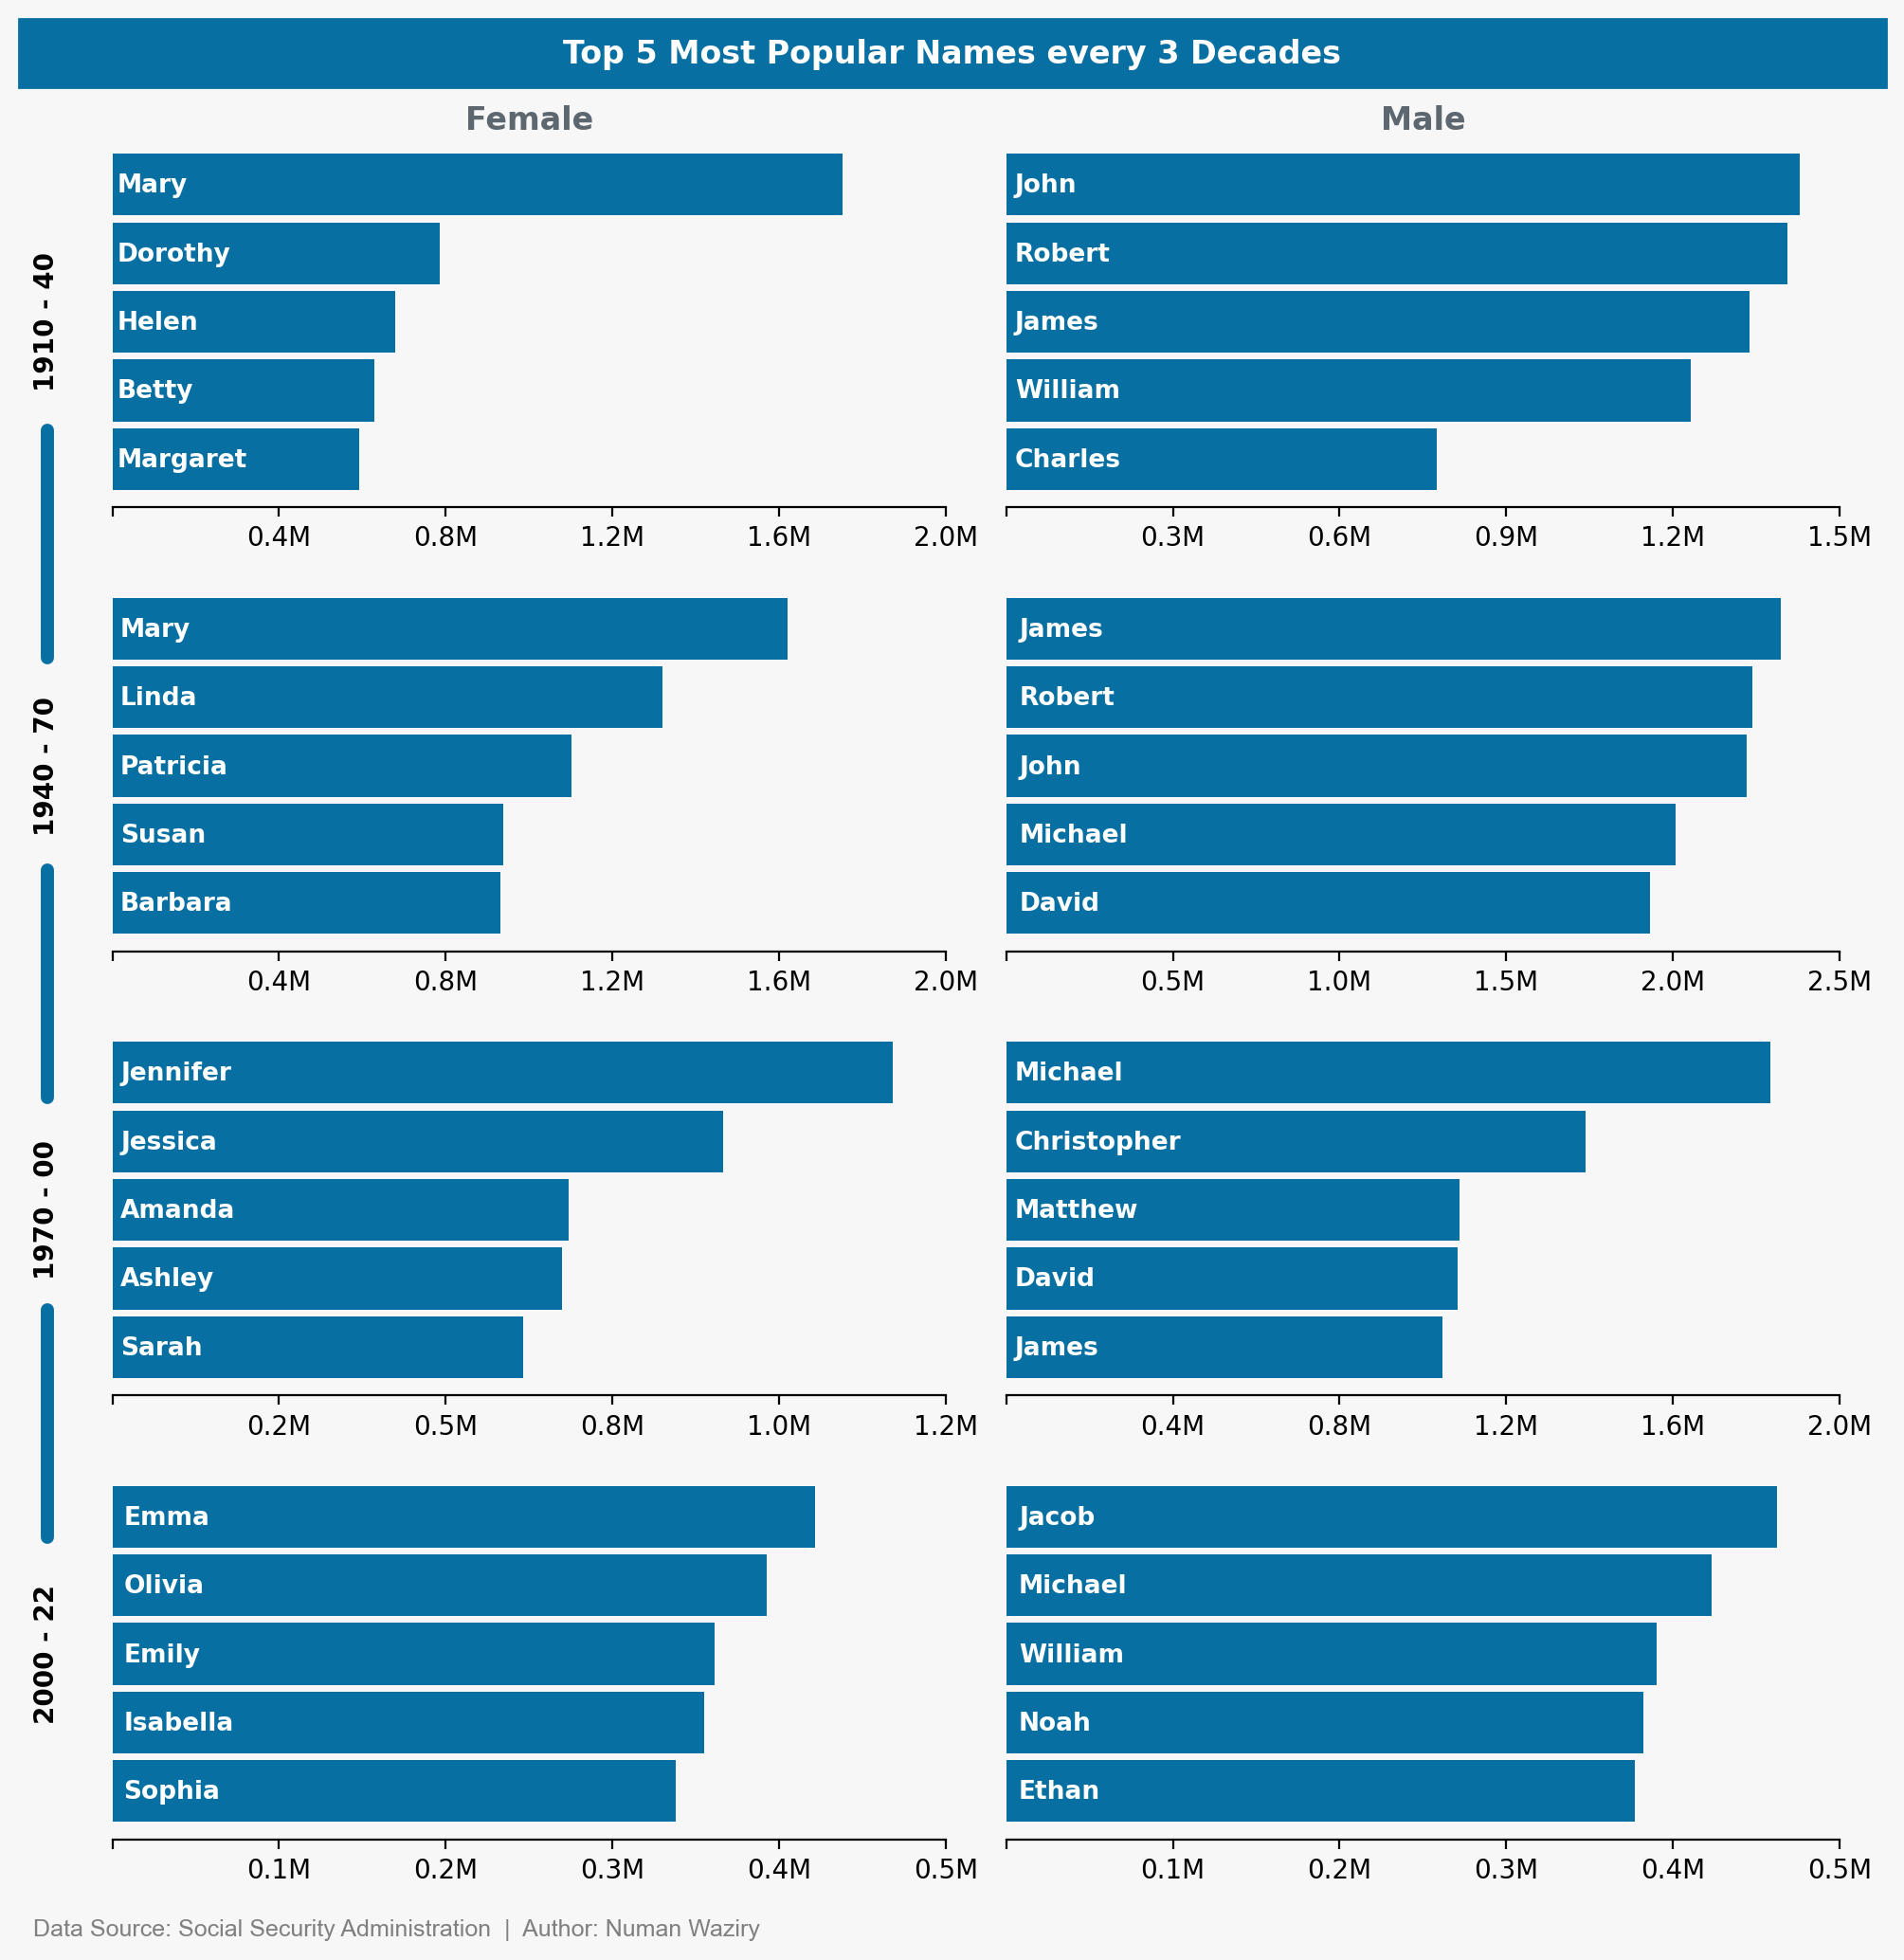

In [13]:
def transform_data(df):
    return (df.groupby([pd.Grouper(key="Year",freq="30AS"),"Gender","Name"]).Births.sum().unstack([0,1]))


def plot_bars(data):
    fig, axes = plt.subplots(4, 2, figsize=(10, 10), dpi=200, facecolor='#F7F7F7')
    BLUE = "#076fa2"
    
    for i, (ax, col) in enumerate(zip(axes.flatten(), data.columns)):
        data[col].nlargest(5).sort_values().plot.barh(ax=ax, color=BLUE, width=0.9)
        ax.set_facecolor("None")
        
        locator = ticker.MaxNLocator(nbins=5)
        ax.xaxis.set_major_locator(locator)
        
        formatter = ticker.FuncFormatter(lambda x, pos: f'{x / 1000000:.1f}M')
        ax.xaxis.set_major_formatter(formatter)
        
        if i % 2 == 0 and i != 6:
            start,end = col[0].strftime('%Y'),str(int(col[0].strftime('%y'))+30)[-2:]
            ax.set_ylabel(f"{start} - {end}", weight='bold', labelpad=20)
            
        elif i==6:
            start,end = col[0].strftime('%Y'),22
            ax.set_ylabel(f"{start} - {end}", weight='bold', labelpad=20)

        else:
            ax.set_ylabel("")
    
        titles = ["Female", "Male"]
        if i < 2:
            ax.set_title(titles[i], pad=0, weight=600, va="bottom", color='#5D676F')
        
        for j, p in enumerate(ax.patches):
            x = min([pp.get_width() * 0.02 for pp in ax.patches])
            color = "white"
            y = p.get_y() 
            ax.text(x, y + 0.5 / 2, ax.get_yticklabels()[j].get_text(), va="bottom", color=color, size=9.5, weight='bold')
        
        ax.tick_params(left=False, labelleft=False)
        ax.set_xticks(ax.get_xticks(), [""] + ax.get_xticklabels()[1:])
    
    return fig

def add_custom_shapes(fig):
    BLUE = "#076fa2"
    rect_width, rect_height, rect_x, rect_y = 0.985, 0.036, 0.5 - 0.985 / 2, 0.963
    fig.add_artist(patches.Rectangle((rect_x, rect_y), rect_width, rect_height, color=BLUE, alpha=1, zorder=0))
    
    length, high, decrease = 0.12, 0.782, 0.112
    for i in range(3):
        line_high = high - (i * length) - (i * decrease)
        line = plt.Line2D([0.0226, 0.0226], [line_high, line_high - length], linestyle='-', lw=5, color=BLUE)
        line.set_solid_capstyle('round')
        fig.add_artist(line)
    return fig

def set_figure_properties(fig):
    fig.suptitle("Top 5 Most Popular Names every 3 Decades", va="center", weight='bold', color='White')
    fig.text(0.015, -0.015, "Data Source: Social Security Administration  |  Author: Numan Waziry", fontname="Arial",
             ha='left', va='bottom', fontsize=9, color='grey')

    return fig


def create_plot(df):
    data = transform_data(df)
    fig = plot_bars(data)
    fig = add_custom_shapes(fig)
    fig = set_figure_properties(fig)
    sns.despine(left=True)
    plt.tight_layout()
    return fig
    
create_plot(df);

## Frequency of top 10 names

In [24]:
def transform_data(df):
    return (
    df.groupby(['Year', 'Gender', 'Name'])
    .Births.sum()
    .groupby(['Year', 'Gender'])
    .apply(lambda x: x.nlargest(10).sum())
    .div(df.groupby(['Year', 'Gender']).Births.sum())
    .unstack()
    )

def plot_line(df):
    GREEN, BLUE, RED  = "#2FC1D3", "#076FA1", "#BE6365"
    fig, ax = plt.subplots(figsize=(9, 5),facecolor="#F7F7F7",dpi=170)
    colors=[BLUE,RED]
    df.plot(ax=ax,lw=3.5,color=colors,xlabel="",
                     path_effects=[path_effects.SimpleLineShadow(shadow_color='black', linewidth=2),path_effects.Normal()])
    ax.grid(axis="y")
    ax.set_facecolor("None")
    ax.spines[:].set_visible(False)
    ax.tick_params(which='both',left=False,bottom=False)
    ax.set_ylim(0.05,0.39)

    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=7))

    # Set the major y tick formatter to display percentages
    def percent_formatter(x, pos):
        return '{:.0%}'.format(x)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*100:.0f}%'))
    ax.legend(labels=["Female","Male"],loc=5,frameon=False)
    return fig, ax

def annotate_plot(fig,title):
    fig.text(0.082, 0.94, title, fontsize=14, fontweight="bold",ha='left',fontname="Arial")
    fig.text(0.082, 0.89, "The trend reflects diversifying naming choices over the century", fontsize=11,ha='left',color="#5C5B5D",fontname="Arial")

    fig.text(0.08, -0.01, "Data Source: Social Security Administration  |  Author: Numan Waziry",fontname="Arial",
            ha='left', va='bottom', fontsize=9, color='grey')

def create_plot(df):
    data = transform_data(df)
    fig,ax = plot_line(data)
    title = f"Proportion of babies born in US given a top 10 Name, 1910-{data.index[-1].year}"
    annotate_plot(fig,title)
    return fig
create_plot(df);

In [15]:
def transform_data(df):
    data = (
        df.groupby(['Year', 'Gender', 'Name'])
        .Births.sum()
        .groupby(['Year', 'Gender'])
        .apply(lambda x: x.nlargest(10).sum())
        .div(df.groupby(['Year', 'Gender']).Births.sum())
        .unstack()
    )
    return data.diff(axis=1).M

def plot_data(ax, diff):
    diff.plot(ax=ax, lw=3.5, color="#009B77", xlabel="", zorder=5,
              path_effects=[path_effects.SimpleLineShadow(shadow_color='black', linewidth=2), path_effects.Normal()])
    ax.set_yticks([0, diff.max()])
    ax.yaxis.set_major_formatter(lambda x, pos: f'{x*100:.1f}%')
    ax.text(-10, 0, "Point of Equal Proportions Between Genders", size=7, color="grey", ha="center",
            path_effects=[path_effects.withStroke(linewidth=8, foreground="#F7F7F7")], va='center')
    ax.axhline(0, color="grey", alpha=0.7, ls="dotted", lw=2)
    sns.despine(ax=ax, left=True)
    ax.annotate("Crossover in 2009: Female Proportions\nSurpass Male for the First Time",
                xy=(diff[diff <= 0].index[0].year-1970, 0), xycoords='data', size=8.5, color="#36454F",
                xytext=(0.68, 0.55), textcoords='axes fraction', ha='left',
                arrowprops=dict(arrowstyle="->", lw=1.5, color="#3E454B"))
    ax.tick_params(labelsize=8.5)
    ax.tick_params(which="minor", length=0)
    ax.tick_params(axis="y", colors='#3E454B', left=False)



def add_notes(ax):
    ax.set_title("Gender Proportion Disparity in Adoption of Top 10 Names Over Time (1910-2022)",
                 fontfamily="Arial", pad=20, size=11, color='#3E454B', zorder=0, fontweight='bold')
    plt.figtext(0.08, -0.17,
                "Note: This line indicates the difference in proportions of males versus females given a top 10 name over time\nPositive values indicate a higher proportion of males and negative values indicate a higher proportion of females with top 10 names.",
                ha="left", fontsize=8, fontname="Arial", color="#36454F", va="bottom")
    plt.figtext(0.08, -0.26,
                "Author: Numan Waziry  |  Data Source: Social Security Administration",
                ha="left", fontsize=7, fontname="Arial", color="grey", va="bottom")

def create_plot(df):
    diff = transform_data(df)
    fig, ax = plt.subplots(figsize=(9, 2), facecolor="#F7F7F7", dpi=170)
    ax.set_facecolor("none")

    plot_data(ax, diff)
    set_plot_title(ax)
    add_notes(ax)



    plt.show()
    return fig

# Example usage:
create_plot(df);


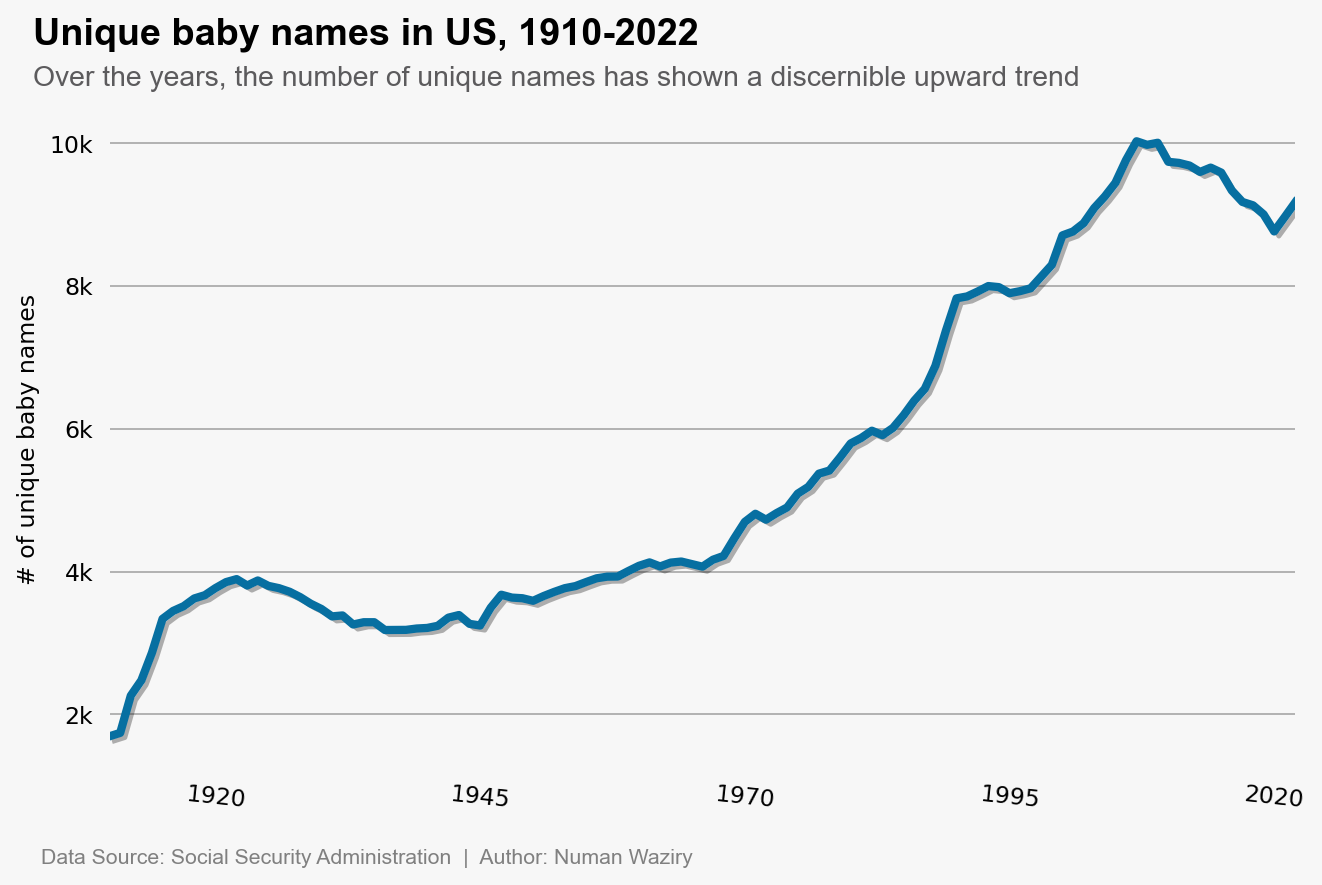

In [16]:
def transform_data(df):
    return (df.groupby(["Year"]).Name.nunique())

def plot_unique_names(data):
    BLUE = "#076FA1"
    GREY_DARKER = "#333333"
    fig, ax = plt.subplots(figsize=(9, 5), facecolor="#F7F7F7", dpi=170)
    colors = BLUE

    data.plot(ax=ax, color=BLUE, lw=3.5, xlabel="", ylabel="# of unique baby names",
                                             path_effects=[path_effects.SimpleLineShadow(shadow_color='black', linewidth=2),
                                                           path_effects.Normal()])
    ax.grid(axis="y")
    ax.set_facecolor("None")
    ax.spines[:].set_visible(False)
    ax.tick_params(which='both', left=False, bottom=False)
    plt.tick_params(axis='x', rotation=-6)
    ax.set_yticks(ax.get_yticks()[1:-1],
                  [str(int(label.get_text())//1000)+"k" for label in ax.get_yticklabels()[1:-1]])

    return fig, ax

def annonate_plot(fig,title):
    fig.text(0.075, 0.96, title, fontsize=16, fontweight="bold", ha='left',
             fontname="Arial")
    fig.text(0.075, 0.91, "Over the years, the number of unique names has shown a discernible upward trend",
             fontsize=12, ha='left', color="#5C5B5D", fontname="Arial")
    fig.text(0.08, -0.01, "Data Source: Social Security Administration  |  Author: Numan Waziry",fontname="Arial",
        ha='left', va='bottom', fontsize=9, color='grey')

def create_plot(df):
    data=transform_data(df)
    fig, ax = plot_unique_names(data)
    title = f"Unique baby names in US, 1910-{data.index[-1].year}"
    annonate_plot(fig,title)
    return fig
    
    
create_plot(df);

In [17]:
def transform_data(df):
    return (df.groupby("Year").Name.nunique() / df.groupby("Year").Births.sum()).mul(100000)

def plot_unique_names(data):
    BLUE, GREY_DARKER = "#076FA1", "#333333"
    fig, ax = plt.subplots(figsize=(9, 5), facecolor="#F7F7F7", dpi=170)
    data.plot(ax=ax, color=BLUE, lw=3.5, xlabel="", ylabel="# of unique baby names  per 100k born",
                                             path_effects=[path_effects.SimpleLineShadow(shadow_color='black', linewidth=2),
                                                           path_effects.Normal()])
    ax.grid(axis="y",zorder=0)
    ax.set_facecolor("None")
    ax.spines[:].set_visible(False)
    ax.tick_params(which='both', left=False, bottom=False)
    plt.tick_params(axis='x', rotation=-6)
    

    return fig, ax

def annonate_plot(fig):
    path_effect = [path_effects.withStroke(linewidth=6, foreground="#E8E8E8")]
    fig.gca().axvspan(-28,-2,alpha=0.12,color="grey", linewidth=0)
    fig.gca().text(-15,300,"The Era of Peak Birth Rates in \nthe United States",rotation=-90,
                   ha="center",va="top",color="#333333",weight="bold",path_effects=path_effect,fontname="Arial")
    fig.text(0.075, 0.96, "Unique baby names per 100k babies born, 1910-2022", fontsize=14, fontweight="bold", ha='left',
             fontname="Arial")
    fig.text(0.075, 0.91, "Inverse relationship between population and proportio of unique names is observed",
             fontsize=12, ha='left', color="#5C5B5D", fontname="Arial")
    fig.text(0.08, -0.01, "Data Source: Social Security Administration  |  Author: Numan Waziry",fontname="Arial",
        ha='left', va='bottom', fontsize=9, color='grey')

def create_plot(df):
    data=transform_data(df)
    fig, ax = plot_unique_names(data)
    annonate_plot(fig)
    return fig
    
create_plot(df);



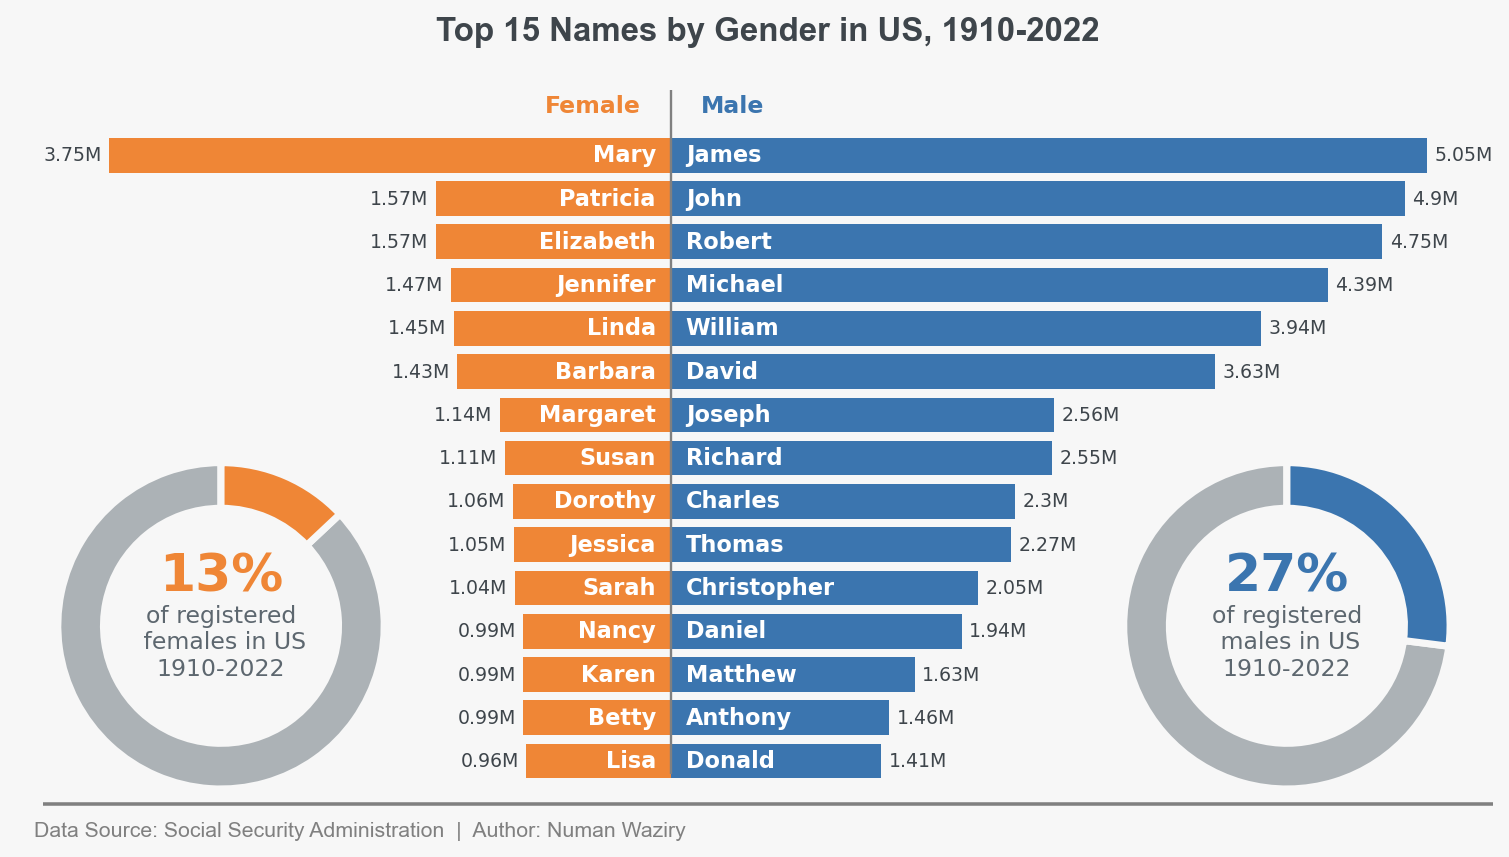

In [18]:
def transform_data(df):
    return pd.concat([
        df[df['Gender'] == 'M'].groupby('Name').sum(numeric_only=True).nlargest(15, "Births").assign(Gender="Male"),
        df[df['Gender'] == 'F'].groupby('Name').sum(numeric_only=True).nlargest(15, "Births").assign(Gender="Female")
    ])

def plot_bar(data, female_color, male_color):
    fig, ax = plt.subplots(figsize=(11,6), dpi=170, facecolor='#F7F7F7')
    data_male = data.query("Gender == 'Male'")
    data_female = data.query("Gender == 'Female'")

    plotA = ax.barh(range(15), data_male.Births,color=male_color)
    plotB = ax.barh(range(15), -data_female.Births,color=female_color)

    for j, (pA, pB) in enumerate(zip(plotA.patches, plotB.patches)):
        ax.text(1e5, j, data_male.index[j], color='white', ha='left', va='center', size=9.5, weight='bold')
        ax.text(pA.get_width() + 5e4, j, f'{round(pA.get_width() / 1e6, 2)}M', ha='left', va='center', size=8, color='#3E454B')
        ax.text(-1e5, j, data_female.index[j], color='white', ha='right', va='center', size=9.5, weight='bold')
        ax.text(pB.get_width() - 5e4, j, f'{round(-pB.get_width() / 1e6, 2)}M', ha='right', va='center', size=8, color='#3E454B')

    ax.text(-2e5, -1, "Female", color=female_color, ha="right", size=10, weight='bold')
    ax.text(2e5, -1, "Male", color=male_color, ha="left", size=10, weight='bold')
    ax.set_title("Top 15 Names by Gender in US, 1910-2022", size=14, color="#3E454B", fontname="Arial", weight='bold')
    fig.text(0.12,0.11, "Data Source: Social Security Administration  |  Author: Numan Waziry",fontname="Arial",
            ha='left', va='bottom', fontsize=9, color='grey')

    ax.axhline(15, color='grey')
    ax.vlines(0, -1.5, 14.3, color="grey", lw=1)
    ax.invert_yaxis()
    ax.set_facecolor("none")
    ax.axis("off")
    
    return fig, ax

def add_pie_chart(fig, axes, data,df, gender, accent_color):
    ax = fig.add_axes(axes)
    ax.axis("square")
    
    prop = round((data.query(f"Gender=='{gender}'").Births.sum() / df.query(f"Gender=='{gender[0]}'").Births.sum()) * 100)
    sizes = [100 - prop, prop]
    colors = ['#ACB2B6', accent_color]
    
    ax.pie(sizes, colors=colors, startangle=90, wedgeprops={"edgecolor": "#F7F7F7", 'linewidth': 3, "width": 0.28})
    
    ax.text(0, 0.3, f"{prop}%", ha='center', va='center', size=22, weight='bold', color=accent_color)
    ax.text(0, -0.1, f"of registered\n {gender.lower()}s in US\n1910-{df.Year.iloc[-1].year}", ha='center', va='center', size=10, color='#5D676F')
    return ax

def create_plot(df, male_color="#3B75AF", female_color="#EF8636"):
    data = transform_data(df)
    fig, ax = plot_bar(data, female_color, male_color)
    ax2 = add_pie_chart(fig, [0.02, 0.12, 0.4, 0.4], data, df, "Female", female_color)
    ax3 = add_pie_chart(fig, [0.59, 0.12, 0.4, 0.4], data, df, "Male", male_color)
    return fig

create_plot(df);